# Complete analysis for Experiment 2, @Magdeburg

In [1]:
rm(list=ls())

In [3]:
library(plyr)
library(dplyr)
library(lme4)
library(ggplot2)
library(BayesFactor)

### Loading and preprocessing data
Loading raw data and converting integer constants to factors

In [4]:
responses <- read.table(file.path('Experiment 2', 'Experiment 2.csv'), sep=',', dec = '.', header = TRUE)

# converting factors and values to a readable format
responses$DisplayType <- revalue(responses$DisplayType, c('H' = 'Horizontally arranged', 'V'= 'Vertically arranged'))
responses$RotationAxis <- plyr::revalue(responses$RotationAxis, c('X'='Horizontal', 'Y'= 'Vertical'))
responses$Percept <- factor(responses$Percept, levels= c(-2, -1, 1), labels= c('unclear', 'counter-rotation', 'co-rotation'))
responses$Background <- factor(responses$Background, levels= c(0, 1), labels= c('absent', 'present'))

# computing axes configuration
responses$Axes.Configuration <- 'parallel'
responses$Axes.Configuration[(responses$DisplayType=='Horizontally arranged') & (responses$RotationAxis=='Horizontal')] <- 'co-axial'
responses$Axes.Configuration[(responses$DisplayType=='Vertically arranged') & (responses$RotationAxis=='Vertical')] <- 'co-axial'
responses$Axes.Configuration <- factor(responses$Axes.Configuration)

In [5]:
head(responses)

ObserverID,DisplayType,RotationAxis,Background,Distance,Percept,Time,Axes.Configuration
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,3.095270,co-axial
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,7.074259,co-axial
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,13.137241,co-axial
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,17.610794,co-axial
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,22.920208,co-axial
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,30.160195,co-axial


### Computing duration of individual percepts

In [4]:
block.duration <- 300 # Duration of a single continuous presentaiton run in seconds
responses$Duration <- NA
responses$Curtailed <- FALSE # duration of the last percept is curtailed by the end-of-the block
for(i.row in 1:(nrow(responses)-1)){
    if (responses$Time[i.row+1]<responses$Time[i.row]){
        # block end?
        if ((responses$ObserverID[i.row+1]!=responses$ObserverID[i.row]) ||
            (responses$DisplayType[i.row+1]!=responses$DisplayType[i.row]) ||
            (responses$RotationAxis[i.row+1]!=responses$RotationAxis[i.row]) ||
            (responses$Background[i.row+1]!=responses$Background[i.row]) ||
            (responses$Distance[i.row+1]!=responses$Distance[i.row])){
            # block end!
            responses$Duration[i.row] <- block.duration-responses$Time[i.row]
            responses$Curtailed[i.row] <- TRUE
        }
        
        else{
            stop(sprintf('What the Fish? Row %d', i.row))
        }
    }
    else{
        responses$Duration[i.row] <- responses$Time[i.row+1]-responses$Time[i.row]
    }
}

### Computing average counter-rotation for all combinations of conditions
In this case we look separately at all for combinations for the objects' arrangement (horizontally vs. vertically arranged) and of the objects' rotation axis (horizontal or vertical)

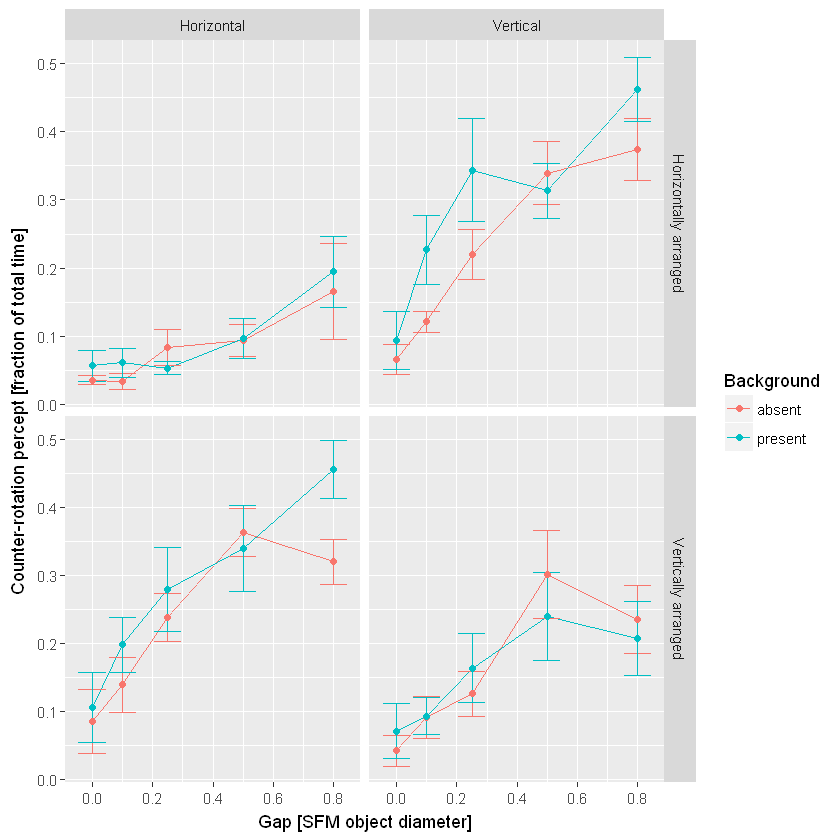

In [5]:
counter.rotation <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration) %>%
    dplyr::group_by(DisplayType, RotationAxis, Background, Distance) %>%
    dplyr::summarize(
        mean.duration= mean(total.duration, na.rm=TRUE),
        serr.duration= sd(total.duration, na.rm=TRUE)/sqrt(n()))

counter.rotation.plot <- ggplot(data= counter.rotation, 
                          aes(x= Distance, y= mean.duration, 
                              ymin= mean.duration-serr.duration,
                              ymax= mean.duration+serr.duration,
                              group= Background, color= Background))+
    geom_line()+
    geom_errorbar()+
    geom_point() + 
    facet_grid(DisplayType ~ RotationAxis)+
    ylab('Counter-rotation percept [fraction of total time]')+
    xlab('Gap [SFM object diameter]')
print(counter.rotation.plot)

In [6]:
head(responses)

ObserverID,DisplayType,RotationAxis,Background,Distance,Percept,Time,Axes.Configuration,Duration,Curtailed
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,3.095270,co-axial,3.978989,FALSE
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,7.074259,co-axial,6.062982,FALSE
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,13.137241,co-axial,4.473553,FALSE
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,17.610794,co-axial,5.309414,FALSE
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,22.920208,co-axial,7.239987,FALSE
af,Horizontally arranged,Horizontal,absent,0.8,co-rotation,30.160195,co-axial,2.978573,FALSE


In [7]:
counter.rotation.per.observer <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance, Axes.Configuration) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration)
#     dplyr::group_by(ObserverID, Background, Axes.Configuration, Distance) %>%
#     dplyr::summarize(
#         mean.duration= mean(total.duration, na.rm=TRUE),
#         serr.duration= sd(total.duration, na.rm=TRUE)/sqrt(n()))

# counter.rotation.per.observer <- data.frame(counter.rotation.per.observer)
# counter.rotation.per.observer$Distance <- as.factor(counter.rotation.per.observer$Distance)
# sort(anovaBF(mean.duration ~ Distance + Axes.Configuration + Background + ObserverID, 
#              data= counter.rotation.per.observer, whichRandom= 'ObserverID'), decreasing= TRUE)


# linear-mixed models
lm.null <- lmer(total.duration ~ (1|ObserverID), data= counter.rotation.per.observer, REML=FALSE)
lm.distance <- update(lm.null, .~. + Distance)
lm.layout <- update(lm.distance, .~. + DisplayType)
lm.axis <- update(lm.layout, .~. + RotationAxis)
lm.axes.conf <- update(lm.axis, .~.  + Axes.Configuration)
lm.bg <- update(lm.axes.conf, .~.+Background)
lm.bg.axes.conf <- update(lm.bg, .~. +Background * Axes.Configuration)
lm.summary <- anova(lm.null, lm.distance, lm.layout, lm.axis, lm.axes.conf, lm.bg, lm.bg.axes.conf)
lm.summary
lm.summary$'Pr(>Chisq)'

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-254.7706,-243.2661,130.3853,-260.7706,NA,NA,NA
lm.distance,4,-355.1831,-339.8439,181.5916,-363.1831,102.412586,1,4.508283e-24
lm.layout,5,-357.1181,-337.9440,183.5590,-367.1181,3.934962,1,4.729222e-02
lm.axis,6,-360.8410,-337.8321,186.4205,-372.8410,5.722900,1,1.674506e-02
lm.axes.conf,7,-457.1890,-430.3453,235.5945,-471.1890,98.347955,1,3.509631e-23
lm.bg,8,-461.0461,-430.3676,238.5230,-477.0461,5.857111,1,1.551424e-02
lm.bg.axes.conf,9,-463.2582,-428.7449,240.6291,-481.2582,4.212180,1,4.013472e-02


[1]           NA 4.508283e-24 4.729222e-02 1.674506e-02 3.509631e-23
[6] 1.551424e-02 4.013472e-02

In [ ]:
counter.rotation.per.observer <- data.frame(counter.rotation.per.observer)
counter.rotation.per.observer$Distance <- as.factor(counter.rotation.per.observer$Distance)
sort(anovaBF(total.duration ~ Distance + DisplayType + RotationAxis + Axes.Configuration + Background + ObserverID, 
             data= counter.rotation.per.observer, whichRandom= 'ObserverID'), decreasing= TRUE)

Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning 

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 constant columns removed from X."Warning message in nWayAOV(y, X, gMap = gMap, rscale = rscale, posterior = posterior, :
"1 const

### Computing average counter-rotation for both axes configurations ignoring presence of the background
Here we only examine the relative axes configuration (parallel vs. co-axial) and ignore the absolute arrangement and axis of rotation

In [ ]:
counter.rotation.for.plotting <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance, Axes.Configuration) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration) %>%
    dplyr::group_by(ObserverID, RotationAxis, Axes.Configuration, Distance) %>%
    dplyr::summarize(total.duration= mean(total.duration, na.rm=TRUE)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(RotationAxis, Axes.Configuration, Distance) %>%
    dplyr::summarize(mean.duration= mean(total.duration, na.rm=TRUE),
                     serr.duration= sd(total.duration, na.rm=TRUE)/sqrt(n()))

counter.rotation.plot <- ggplot(data= counter.rotation.for.plotting, 
                          aes(x= Distance+0.1, y= mean.duration, 
                              ymin= mean.duration-serr.duration,
                              ymax= mean.duration+serr.duration,
                              group= RotationAxis, color= RotationAxis))+
    geom_line()+
    geom_errorbar()+
    geom_point() + 
    facet_grid( .~ Axes.Configuration)+
    scale_x_log10(breaks= unique(counter.rotation.for.plotting$Distance)+0.1, 
                  labels= unique(counter.rotation.for.plotting$Distance))+
    theme(panel.grid.minor.x=  element_blank())+
    ylab('Counter-rotation percept [fraction of total time]')+
    xlab('Gap [SFM object diameter]')
print(counter.rotation.plot)
ggsave('Exp1a - overall.pdf', counter.rotation.plot, width= 16, height= 8, units = 'cm')

In [ ]:
counter.rotation.for.plotting <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance, Axes.Configuration) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration) %>%
    dplyr::group_by(ObserverID, Axes.Configuration, Distance) %>%
    dplyr::summarize(
        mean.duration= mean(total.duration, na.rm=TRUE))

# plotting
counter.rotation.plot <- ggplot(data= counter.rotation.for.plotting, 
                          aes(x= Distance, y= mean.duration, group= Distance, color= ObserverID))+
    geom_boxplot()+
    geom_jitter()+
    scale_x_continuous(breaks = sort(unique(counter.rotation.for.plotting$Distance)))+
    ylab('Counter-rotation percept [fraction of total time]')+
    xlab('Gap [SFM object diameter]')+
    facet_grid(Axes.Configuration ~ ., scale = 'free')
print(counter.rotation.plot)
# ggsave('Exp 1A - main effect of gap.pdf', counter.rotation.plot)

## Examining two configurations independently

In [ ]:
counter.rotation.per.observer <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance, Axes.Configuration) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration) %>%
    dplyr::group_by(ObserverID, Axes.Configuration, Background, Distance) %>%
    dplyr::summarize(mean.duration= mean(total.duration, na.rm=TRUE))

#### Co-axial

In [ ]:
coaxial.per.observer <- subset(counter.rotation.per.observer, Axes.Configuration== 'co-axial')
lm.null <- lmer(mean.duration ~ (1|ObserverID), data= coaxial.per.observer, REML=FALSE)
lm.distance <- update(lm.null, .~. + Distance)
lm.bg <- update(lm.distance, .~.+Background)
anova(lm.null, lm.distance, lm.bg)

#### Parallel

In [ ]:
parallel.per.observer <- subset(counter.rotation.per.observer, Axes.Configuration== 'parallel')
lm.null <- lmer(mean.duration ~ (1|ObserverID), data= parallel.per.observer, REML=FALSE)
lm.distance <- update(lm.null, .~. + Distance)
lm.bg <- update(lm.distance, .~.+Background)
anova(lm.null, lm.distance, lm.bg)